In [7]:
import numpy as np
import pandas as pd

In [8]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"aakashlodha","key":"ae1cfaf0b713f505bb31444a65c823e5"}'}

In [9]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
!kaggle datasets download -d usdot/flight-delays


Dataset URL: https://www.kaggle.com/datasets/usdot/flight-delays
License(s): CC0-1.0
flight-delays.zip: Skipping, found more recently modified local copy (use --force to force download)


In [11]:
!unzip flight-delays.zip


Archive:  flight-delays.zip
replace airlines.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: airlines.csv            
replace airports.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: airports.csv            
replace flights.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: flights.csv             y



In [12]:
flights = pd.read_csv('/content/flights.csv', low_memory=False)
print(len(flights))

5819079


In [13]:
flights = flights.sample(frac=0.5, random_state=42)
flights.to_csv("flights.csv", index=False)  # overwrites the original file


In [14]:
print(len(flights))

2909540


In [15]:
flights[flights['MONTH'] == 10]['ORIGIN_AIRPORT'].unique()

array(['14635', '14869', '11298', '10713', '12892', '14747', '11433',
       '13232', '10821', '12173', '14893', '14771', '14100', '13930',
       '10599', '13495', '10397', '11618', '12478', '13204', '14193',
       '13871', '10423', '11057', '12889', '14683', '11292', '14107',
       '15016', '14576', '10529', '11977', '10792', '12519', '13487',
       '13277', '13433', '11259', '11278', '11697', '12264', '15370',
       '13970', '13851', '10693', '10721', '10781', '15412', '12266',
       '14831', '14570', '14843', '14492', '12953', '10561', '14122',
       '13796', '11140', '14783', '10849', '14057', '10785', '13158',
       '13891', '13342', '11995', '11066', '14908', '13577', '11986',
       '13377', '11267', '13244', '15919', '13198', '11973', '14679',
       '11823', '12451', '11049', '13303', '11884', '11423', '14307',
       '14814', '10208', '13830', '12191', '12523', '10257', '12441',
       '14730', '13241', '10980', '10627', '13422', '15304', '10994',
       '14025', '134

In [16]:
flights = flights[flights['MONTH'] != 10]

In [17]:
columns_to_use = [
    'TAIL_NUMBER',
    'ORIGIN_AIRPORT',
    'DESTINATION_AIRPORT',
    'AIRLINE',
    'SCHEDULED_DEPARTURE',
    'DEPARTURE_TIME',
    'DEPARTURE_DELAY',
    'SCHEDULED_ARRIVAL',
    'ARRIVAL_TIME',
    'ARRIVAL_DELAY',
    'SCHEDULED_TIME',
    'ELAPSED_TIME',
    'AIRLINE_DELAY',
    'WEATHER_DELAY',
    'AIR_SYSTEM_DELAY',
    'SECURITY_DELAY',
    'LATE_AIRCRAFT_DELAY',
    'MONTH',
    'DAY'
]

flights = flights[columns_to_use]
flights.dtypes

,0
TAIL_NUMBER,object
ORIGIN_AIRPORT,object
DESTINATION_AIRPORT,object
AIRLINE,object
SCHEDULED_DEPARTURE,int64
DEPARTURE_TIME,float64
DEPARTURE_DELAY,float64
SCHEDULED_ARRIVAL,int64
ARRIVAL_TIME,float64
ARRIVAL_DELAY,float64


In [18]:
non_nullable_cols = [
    'TAIL_NUMBER',
    'ORIGIN_AIRPORT',
    'DESTINATION_AIRPORT',
    'AIRLINE',
    'SCHEDULED_DEPARTURE',
    'DEPARTURE_TIME',
    'DEPARTURE_DELAY',
    'SCHEDULED_ARRIVAL',
    'ARRIVAL_TIME',
    'SCHEDULED_TIME',
    'ELAPSED_TIME',
    'ARRIVAL_DELAY',
    'MONTH',
    'DAY'
]

print(len(flights))
flights = flights.dropna(subset= non_nullable_cols)
print(len(flights))

2666729
2615827


In [19]:
flights.drop_duplicates(inplace= True)
print(len(flights))

2615827


In [20]:
flights['SCHEDULE_CROSSES_DAY'] = (flights['SCHEDULED_DEPARTURE'] > flights['SCHEDULED_ARRIVAL']).apply(lambda x : int(x))
flights['DEPARTURED_PAST_DAY'] = (flights['DEPARTURE_TIME'] > flights['ARRIVAL_TIME']).apply(lambda x : int(x))
flights['DEPARTURED_NEXT_DAY'] = (flights['DEPARTURE_TIME'] + 800 < flights['SCHEDULED_DEPARTURE']).apply(lambda x : int(x))
flights['ARRIVED_NEXT_DAY'] = (flights['ARRIVAL_TIME'] + 800 < flights['SCHEDULED_DEPARTURE']).apply(lambda x : int(x))
print(flights['SCHEDULE_CROSSES_DAY'].sum())
print(flights['DEPARTURED_PAST_DAY'].sum())
print(flights['DEPARTURED_NEXT_DAY'].sum())
print(flights['ARRIVED_NEXT_DAY'].sum())

83502
107390
7953
104838


In [21]:
month_to_minutes = [0] + [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
month_to_minutes = [i*1440 for i in month_to_minutes]
for i in range(1, 13):
    month_to_minutes[i] += month_to_minutes[i-1]
day_to_minutes = [0] + [i*1440 for i in range(1, 32)]

def date_to_minutes(month, day, military_hour):
    def to_minutes_of_day(military_hour):
        hour = military_hour//100
        minutes = military_hour%100
        return (hour*60 + minutes)
    return int(month_to_minutes[month - 1] + day_to_minutes[day - 1] + to_minutes_of_day(military_hour))

In [22]:
flights['SCHEDULED_DEPARTURE'] = flights[['MONTH', 'DAY', 'SCHEDULED_DEPARTURE']].apply(
    lambda row : date_to_minutes(row['MONTH'], row['DAY'], row['SCHEDULED_DEPARTURE']),
    axis = 1
)

In [23]:
flights['SCHEDULED_ARRIVAL'] = flights[['MONTH', 'DAY', 'SCHEDULED_ARRIVAL', 'SCHEDULE_CROSSES_DAY']].apply(
    lambda row :
    (
        date_to_minutes(row['MONTH'], row['DAY'], row['SCHEDULED_ARRIVAL'])
        + 1440*row['SCHEDULE_CROSSES_DAY']
    ),
    axis = 1
)

In [24]:
flights['DEPARTURE_TIME'] = flights['DEPARTURE_TIME'].apply(lambda x : int(x))
flights['DEPARTURE_TIME'] = flights[['MONTH', 'DAY', 'DEPARTURE_TIME', 'DEPARTURED_PAST_DAY', 'DEPARTURED_NEXT_DAY']].apply(
    lambda row :
    (
        date_to_minutes(row['MONTH'], row['DAY'], row['DEPARTURE_TIME'])
        - row['DEPARTURED_PAST_DAY']*1440
        + row['DEPARTURED_NEXT_DAY']*1440
    ),
    axis = 1
)

In [25]:
flights['ARRIVAL_TIME'] = flights['ARRIVAL_TIME'].apply(lambda x : int(x))
flights['ARRIVAL_TIME'] = flights[['MONTH', 'DAY', 'ARRIVAL_TIME', 'ARRIVED_NEXT_DAY']].apply(
    lambda row :
    (
        date_to_minutes(row['MONTH'], row['DAY'], row['ARRIVAL_TIME'])
        + row['ARRIVED_NEXT_DAY']*1440
    ),
        axis = 1
)

In [26]:
def traverses_date(month, day, hour, departure, arrival):
    date = date_to_minutes(month, day, hour)
    return (departure < date) and (arrival > date)

flights['VALID_ROW'] = flights[['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL']].apply(
    lambda row : not(
        traverses_date(4, 5, 200, row['SCHEDULED_DEPARTURE'], row['SCHEDULED_ARRIVAL'])
        or
        traverses_date(10, 30, 100, row['SCHEDULED_DEPARTURE'], row['SCHEDULED_ARRIVAL'])
    ),
    axis= 1
)
print(len(flights))
flights = flights[flights['VALID_ROW']]
len(flights)

2615827


2615672

In [27]:
def valid_row(row):
    return(
        (row['SCHEDULED_DEPARTURE'] + row['DEPARTURE_DELAY'] == row['DEPARTURE_TIME'])
        and
        (row['SCHEDULED_ARRIVAL'] + row['ARRIVAL_DELAY'] == row['ARRIVAL_TIME'])
    )

flights['VALID_ROW'] = flights[['SCHEDULED_TIME', 'ELAPSED_TIME', 'SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'DEPARTURE_TIME', 'ARRIVAL_TIME', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY']].apply(valid_row, axis= 1)
print(flights['VALID_ROW'].apply(lambda x : int(x)).sum())

2507294


In [28]:
flights = flights.sort_values(by= ['TAIL_NUMBER', 'SCHEDULED_DEPARTURE'])
flights

,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,AIRLINE,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,...,AIR_SYSTEM_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,MONTH,DAY,SCHEDULE_CROSSES_DAY,DEPARTURED_PAST_DAY,DEPARTURED_NEXT_DAY,ARRIVED_NEXT_DAY,VALID_ROW
3055380,7819A,BNA,LGA,WN,275400,275396,-4.0,275590,275583,-7.0,...,NaN,NaN,NaN,7,11,0,0,0,0,True
3061230,7819A,STL,ATL,WN,275760,275756,-4.0,275915,275900,-15.0,...,NaN,NaN,NaN,7,11,0,0,0,0,True
3065979,7819A,TPA,MSY,WN,276080,276224,144.0,276115,276239,124.0,...,0.0,0.0,97.0,7,11,0,0,0,0,True
3066890,7819A,MSY,DEN,WN,276145,276270,125.0,276255,276359,104.0,...,0.0,0.0,103.0,7,11,0,0,0,0,True
3068892,7819A,DEN,OAK,WN,276310,274965,95.0,276405,276493,88.0,...,0.0,0.0,88.0,7,11,0,1,0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5791329,N9EAMQ,BNA,ORD,MQ,523135,523130,-5.0,523248,523319,71.0,...,71.0,0.0,0.0,12,30,0,0,0,0,True
5794246,N9EAMQ,ORD,SAT,MQ,523310,523415,105.0,523490,523622,132.0,...,27.0,0.0,49.0,12,30,0,0,0,0,True
5803058,N9EAMQ,ORD,ROC,MQ,523855,523853,-2.0,524013,524014,1.0,...,NaN,NaN,NaN,12,30,0,0,0,0,True
5809815,N9EAMQ,ROC,ORD,MQ,524740,524740,0.0,524810,524797,-13.0,...,NaN,NaN,NaN,12,31,0,0,0,0,True


In [29]:
flights['MATCH_TAIL_NUMBER'] = flights['TAIL_NUMBER'] == flights['TAIL_NUMBER'].shift(1, fill_value= 0)
flights['MATCH_AIRPORT'] = flights['ORIGIN_AIRPORT'] == flights['DESTINATION_AIRPORT'].shift(1, fill_value= 0)
flights['MATCH'] = (flights['MATCH_TAIL_NUMBER'] & flights['MATCH_AIRPORT']).apply(lambda x : int(x))
flights['SCHEDULED_STATIONED_TIME'] = (flights['SCHEDULED_DEPARTURE'] - flights['SCHEDULED_ARRIVAL'].shift(1, fill_value= 0))*flights['MATCH']

In [30]:
total_flights = len(flights)
print("From the total number of flights: " + str(total_flights))
total_stationed_times_calculated = len(flights[flights['MATCH'] == 1])
print("We could compute the scheduled_stationed_time of: " + str(total_stationed_times_calculated))
non_positives = flights[(flights['SCHEDULED_STATIONED_TIME'] <= 0) & (flights['MATCH'] == 1)]
print("Of which were non positive: " + str(len(non_positives)))
print("The " + str(round((len(non_positives)*100)/total_stationed_times_calculated, 3)) + "% of those computed")

From the total number of flights: 2615672
We could compute the scheduled_stationed_time of: 1425956
Of which were non positive: 13053
The 0.915% of those computed


In [31]:
flights = flights[(flights['SCHEDULED_STATIONED_TIME'] > 0) | (flights['MATCH'] == 0)]
len(flights)

2602619

In [32]:
n_filas = len(flights)
flights['TEST'] = 0
test_flights = flights.sample(n= int(n_filas*0.2),replace= False)
test_flights['TEST'] = 1
flights.update(test_flights)
flights['TEST'].value_counts()

<ipython-input-32-ea45209e8ae4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flights['TEST'] = 0


,count
TEST,
0,2082096
1,520523


In [33]:
columns_to_use = [
    'AIRLINE',
    'ORIGIN_AIRPORT',
    'DESTINATION_AIRPORT',
    'MONTH',
    'DEPARTURE_TIME',
    'DEPARTURE_DELAY',
    'ARRIVAL_TIME',
    'ARRIVAL_DELAY',
    'AIRLINE_DELAY',
    'WEATHER_DELAY',
    'AIR_SYSTEM_DELAY',
    'SECURITY_DELAY',
    'LATE_AIRCRAFT_DELAY',
    'TEST'
]
delay_causes_data = flights[columns_to_use]
delay_causes_data = delay_causes_data.fillna(0)
delay_causes_data

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,MONTH,DEPARTURE_TIME,DEPARTURE_DELAY,ARRIVAL_TIME,ARRIVAL_DELAY,AIRLINE_DELAY,WEATHER_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,TEST
3055380,WN,BNA,LGA,7,275396,-4.0,275583,-7.0,0.0,0.0,0.0,0.0,0.0,0
3061230,WN,STL,ATL,7,275756,-4.0,275900,-15.0,0.0,0.0,0.0,0.0,0.0,0
3065979,WN,TPA,MSY,7,276224,144.0,276239,124.0,27.0,0.0,0.0,0.0,97.0,0
3066890,WN,MSY,DEN,7,276270,125.0,276359,104.0,1.0,0.0,0.0,0.0,103.0,0
3068892,WN,DEN,OAK,7,274965,95.0,276493,88.0,0.0,0.0,0.0,0.0,88.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5791329,MQ,BNA,ORD,12,523130,-5.0,523319,71.0,0.0,0.0,71.0,0.0,0.0,0
5794246,MQ,ORD,SAT,12,523415,105.0,523622,132.0,0.0,56.0,27.0,0.0,49.0,0
5803058,MQ,ORD,ROC,12,523853,-2.0,524014,1.0,0.0,0.0,0.0,0.0,0.0,1
5809815,MQ,ROC,ORD,12,524740,0.0,524797,-13.0,0.0,0.0,0.0,0.0,0.0,0


In [34]:
columns_to_use = [
    'TAIL_NUMBER',
    'AIRLINE',
    'MONTH',
    'ORIGIN_AIRPORT',
    'DESTINATION_AIRPORT',
    'SCHEDULED_STATIONED_TIME',
    'SCHEDULED_DEPARTURE',
    'DEPARTURE_DELAY',
    'SCHEDULED_ARRIVAL',
    'ARRIVAL_DELAY',
    'MATCH',
    'TEST'
]
clean_flights_data = flights[columns_to_use]
clean_flights_data

,TAIL_NUMBER,AIRLINE,MONTH,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_STATIONED_TIME,SCHEDULED_DEPARTURE,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,MATCH,TEST
3055380,7819A,WN,7,BNA,LGA,0,275400,-4.0,275590,-7.0,0,0
3061230,7819A,WN,7,STL,ATL,0,275760,-4.0,275915,-15.0,0,0
3065979,7819A,WN,7,TPA,MSY,0,276080,144.0,276115,124.0,0,0
3066890,7819A,WN,7,MSY,DEN,30,276145,125.0,276255,104.0,1,0
3068892,7819A,WN,7,DEN,OAK,55,276310,95.0,276405,88.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5791329,N9EAMQ,MQ,12,BNA,ORD,565,523135,-5.0,523248,71.0,1,0
5794246,N9EAMQ,MQ,12,ORD,SAT,62,523310,105.0,523490,132.0,1,0
5803058,N9EAMQ,MQ,12,ORD,ROC,0,523855,-2.0,524013,1.0,0,1
5809815,N9EAMQ,MQ,12,ROC,ORD,727,524740,0.0,524810,-13.0,1,0


In [35]:
columns_to_use = ['TAIL_NUMBER',
                  'SCHEDULED_DEPARTURE',
                  'DEPARTURE_TIME',
                  'ARRIVAL_TIME',
                  'ORIGIN_AIRPORT',
                  'DESTINATION_AIRPORT'
                 ]
airport_saturation_data = flights[columns_to_use]

In [36]:
delay_causes_data.to_csv('delay_causes_data.csv', index= False)
clean_flights_data.to_csv('clean_flights_data.csv', index= False)
airport_saturation_data.to_csv('airport_saturation_data.csv', index= False)

**Airport Saturation Data**

In [37]:
flights = pd.read_csv('/content/airport_saturation_data.csv')
flights

,TAIL_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,ARRIVAL_TIME,ORIGIN_AIRPORT,DESTINATION_AIRPORT
0,7819A,275400,275396,275583,BNA,LGA
1,7819A,275760,275756,275900,STL,ATL
2,7819A,276080,276224,276239,TPA,MSY
3,7819A,276145,276270,276359,MSY,DEN
4,7819A,276310,274965,276493,DEN,OAK
...,...,...,...,...,...,...
2602614,N9EAMQ,523135,523130,523319,BNA,ORD
2602615,N9EAMQ,523310,523415,523622,ORD,SAT
2602616,N9EAMQ,523855,523853,524014,ORD,ROC
2602617,N9EAMQ,524740,524740,524797,ROC,ORD


In [38]:
airports = set(list(flights['ORIGIN_AIRPORT'].unique()) + list(flights['DESTINATION_AIRPORT'].unique()))
saturation = {airport : {} for airport in airports}
for flight in flights.itertuples(index= False):
    origin = flight.ORIGIN_AIRPORT
    destination = flight.DESTINATION_AIRPORT
    departure = flight.DEPARTURE_TIME // 5
    arrival = flight.ARRIVAL_TIME // 5

    saturation[origin][departure] = saturation[origin].get(departure, 0) + 1
    saturation[destination][arrival] = saturation[destination].get(arrival, 0) + 1

In [39]:
for airport, flights_dict in saturation.items():
    max_transit = max(flights_dict.values())
    for key in flights_dict:
        flights_dict[key] = flights_dict[key] / max_transit

In [40]:
origin_saturation = []
destination_saturation = []

def get_saturation_from(airport, time):
    """Suma ponderada de las saturaciones alrededor del momento del aterrizaje"""
    suma = 0.5*saturation[airport][time]
    suma += 0.25*saturation[airport].get(time - 1, 0)
    suma += 0.125*saturation[airport].get(time + 1, 0) #El futuro
    suma += 0.125*saturation[airport].get(time - 2, 0)
    return suma

for flight in flights.itertuples(index= False):
    origin = flight.ORIGIN_AIRPORT
    destination = flight.DESTINATION_AIRPORT
    departure = flight.DEPARTURE_TIME // 5
    arrival = flight.ARRIVAL_TIME // 5
    origin_saturation.append(get_saturation_from(origin, departure))
    destination_saturation.append(get_saturation_from(destination, arrival))

flights['ORIGIN_SATURATION'] = pd.DataFrame(origin_saturation, columns= ['ORIGIN_SATURATION'])
flights['DESTINATION_SATURATION'] = pd.DataFrame(destination_saturation, columns= ['DESTINATION_SATURATION'])

In [41]:
flights = flights[['TAIL_NUMBER', 'SCHEDULED_DEPARTURE', 'ORIGIN_SATURATION', 'DESTINATION_SATURATION']]
flights

,TAIL_NUMBER,SCHEDULED_DEPARTURE,ORIGIN_SATURATION,DESTINATION_SATURATION
0,7819A,275400,0.312500,0.137500
1,7819A,275760,0.187500,0.190476
2,7819A,276080,0.267857,0.175000
3,7819A,276145,0.225000,0.150000
4,7819A,276310,0.183333,0.083333
...,...,...,...,...
2602614,N9EAMQ,523135,0.166667,0.298611
2602615,N9EAMQ,523310,0.125000,0.125000
2602616,N9EAMQ,523855,0.284722,0.166667
2602617,N9EAMQ,524740,0.375000,0.305556


In [42]:
flights.describe().T

,count,mean,std,min,25%,50%,75%,max
SCHEDULED_DEPARTURE,2602619.0,249785.668547,148589.843852,5.00000,125225.000000,242830.000000,358196.000000,525599.000000
ORIGIN_SATURATION,2602619.0,0.221850,0.095294,0.02381,0.156250,0.208333,0.275000,0.758333
DESTINATION_SATURATION,2602619.0,0.210886,0.092631,0.02381,0.144231,0.200000,0.259615,0.758333


In [43]:
flights.to_csv('flights_saturations', index= False)

**Airport Encoding analysis 1**

In [44]:
flights = pd.read_csv('/content/delay_causes_data.csv')
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2602619 entries, 0 to 2602618
Data columns (total 14 columns):
 #   Column               Dtype  
---  ------               -----  
 0   AIRLINE              object 
 1   ORIGIN_AIRPORT       object 
 2   DESTINATION_AIRPORT  object 
 3   MONTH                int64  
 4   DEPARTURE_TIME       int64  
 5   DEPARTURE_DELAY      float64
 6   ARRIVAL_TIME         int64  
 7   ARRIVAL_DELAY        float64
 8   AIRLINE_DELAY        float64
 9   WEATHER_DELAY        float64
 10  AIR_SYSTEM_DELAY     float64
 11  SECURITY_DELAY       float64
 12  LATE_AIRCRAFT_DELAY  float64
 13  TEST                 int64  
dtypes: float64(7), int64(4), object(3)
memory usage: 278.0+ MB


In [45]:
airlines = pd.DataFrame(flights['AIRLINE'].unique(), columns= ['AIRLINE'])
airlines['TOTAL_FLIGHTS'] = airlines['AIRLINE'].apply(lambda row : len(flights[flights['AIRLINE'] == row]))
airlines

,AIRLINE,TOTAL_FLIGHTS
0,WN,567005
1,DL,394849
2,AA,316669
3,MQ,127669
4,EV,252241
5,US,97248
6,OO,262605
7,UA,229885
8,B6,119969
9,F9,40732


In [46]:
delayed_flights = flights[(flights['DEPARTURE_DELAY'] >= 15) | (flights['ARRIVAL_DELAY'] >= 15)]
len(delayed_flights)

593435

In [47]:
print(len(delayed_flights[delayed_flights['AIRLINE_DELAY'] + delayed_flights['WEATHER_DELAY'] + delayed_flights['AIR_SYSTEM_DELAY'] + delayed_flights['SECURITY_DELAY'] + delayed_flights['LATE_AIRCRAFT_DELAY'] > 0]))

491463


In [48]:
airline_delays = delayed_flights[delayed_flights['AIRLINE_DELAY'] > 0]
airline_delays

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,MONTH,DEPARTURE_TIME,DEPARTURE_DELAY,ARRIVAL_TIME,ARRIVAL_DELAY,AIRLINE_DELAY,WEATHER_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,TEST
2,WN,TPA,MSY,7,276224,144.0,276239,124.0,27.0,0.0,0.0,0.0,97.0,0
3,WN,MSY,DEN,7,276270,125.0,276359,104.0,1.0,0.0,0.0,0.0,103.0,0
12,WN,DEN,MSP,7,280426,46.0,280595,40.0,4.0,0.0,0.0,0.0,36.0,1
28,WN,LAS,SJC,7,288983,23.0,289058,18.0,5.0,0.0,0.0,0.0,13.0,0
36,WN,LAX,RNO,7,293002,12.0,293081,16.0,12.0,0.0,4.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2602496,MQ,ROC,ORD,11,460301,37.0,460366,34.0,34.0,0.0,0.0,0.0,0.0,0
2602511,MQ,DFW,XNA,11,467800,35.0,467878,43.0,35.0,0.0,8.0,0.0,0.0,0
2602537,MQ,PIT,ORD,12,483164,53.0,483201,40.0,3.0,0.0,0.0,0.0,37.0,0
2602576,MQ,DFW,OKC,12,497793,28.0,497841,20.0,20.0,0.0,0.0,0.0,0.0,0


In [49]:
airlines['TOTAL_DELAYS'] = airlines['AIRLINE'].apply(
    lambda row : len(airline_delays[airline_delays['AIRLINE'] == row])
)
airlines['GLOBAL_DELAYS_PROPORTION'] = round((airlines['TOTAL_DELAYS']*6)/(airlines['TOTAL_FLIGHTS']*5), 3)
airlines[['AIRLINE', 'GLOBAL_DELAYS_PROPORTION']]

,AIRLINE,GLOBAL_DELAYS_PROPORTION
0,WN,0.140
1,DL,0.088
2,AA,0.116
3,MQ,0.120
4,EV,0.116
5,US,0.120
6,OO,0.079
7,UA,0.158
8,B6,0.176
9,F9,0.160


In [50]:
airlines['GLOBAL_AVG_DELAY'] = airlines['AIRLINE'].apply(
    lambda name : round(airline_delays[airline_delays['AIRLINE'] == name]['AIRLINE_DELAY'].mean(), 1)
)
airlines[['AIRLINE', 'GLOBAL_AVG_DELAY']]

,AIRLINE,GLOBAL_AVG_DELAY
0,WN,25.1
1,DL,41.2
2,AA,40.3
3,MQ,38.0
4,EV,43.0
5,US,31.8
6,OO,50.8
7,UA,33.6
8,B6,26.3
9,F9,30.1


In [51]:
airlines[['GLOBAL_DELAYS_PROPORTION', 'GLOBAL_AVG_DELAY']].corr()

,GLOBAL_DELAYS_PROPORTION,GLOBAL_AVG_DELAY
GLOBAL_DELAYS_PROPORTION,1.000000,-0.629314
GLOBAL_AVG_DELAY,-0.629314,1.000000


In [52]:
airlines = airlines[['AIRLINE', 'GLOBAL_DELAYS_PROPORTION', 'GLOBAL_AVG_DELAY']]
airlines

,AIRLINE,GLOBAL_DELAYS_PROPORTION,GLOBAL_AVG_DELAY
0,WN,0.140,25.1
1,DL,0.088,41.2
2,AA,0.116,40.3
3,MQ,0.120,38.0
4,EV,0.116,43.0
5,US,0.120,31.8
6,OO,0.079,50.8
7,UA,0.158,33.6
8,B6,0.176,26.3
9,F9,0.160,30.1


In [53]:
airlines.to_csv('airlines_encoding.csv', index= False)

**Airport Encoding Analysis 2**

In [54]:
flights = pd.read_csv('/content/delay_causes_data.csv')

In [55]:
columns_to_use = [
    'ORIGIN_AIRPORT',
    'DESTINATION_AIRPORT',
    'MONTH',
    'DEPARTURE_TIME',
    'DEPARTURE_DELAY',
    'ARRIVAL_TIME',
    'ARRIVAL_DELAY',
    'WEATHER_DELAY',
    'AIR_SYSTEM_DELAY',
]
flights = flights[columns_to_use]
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2602619 entries, 0 to 2602618
Data columns (total 9 columns):
 #   Column               Dtype  
---  ------               -----  
 0   ORIGIN_AIRPORT       object 
 1   DESTINATION_AIRPORT  object 
 2   MONTH                int64  
 3   DEPARTURE_TIME       int64  
 4   DEPARTURE_DELAY      float64
 5   ARRIVAL_TIME         int64  
 6   ARRIVAL_DELAY        float64
 7   WEATHER_DELAY        float64
 8   AIR_SYSTEM_DELAY     float64
dtypes: float64(4), int64(3), object(2)
memory usage: 178.7+ MB


In [56]:
airports = set(list(flights['ORIGIN_AIRPORT'].unique()) + list(flights['DESTINATION_AIRPORT'].unique()))
airports = pd.DataFrame(airports, columns = ['AIRPORT'])
airports

,AIRPORT
0,CAK
1,RKS
2,IND
3,COU
4,OGG
...,...
317,ACV
318,CHO
319,FWA
320,LWS


In [57]:
airport_flights = {airport : 0 for airport in airports['AIRPORT'].values}
airport_month_flights = {
    airport : [0 for i in range(0, 13)]
    for airport in airports['AIRPORT'].values
} #El 0 no es nada
airport_delays = {airport : [0, 0] for airport in airports['AIRPORT'].values}
airport_weather_delays = {
    airport : {month : [0, 0] for month in range(0, 13)} #El mes 0 es el total
    for airport in airports['AIRPORT'].values
}
airport_saturation = {airport : {} for airport in airports['AIRPORT'].values}
month_flights = {month : 0 for month in range(0, 13)}
month_weather_delays = {month : [0, 0] for month in range(0, 13)}

In [58]:
for flight in flights.itertuples(index= False):
    origin = flight.ORIGIN_AIRPORT
    destination = flight.DESTINATION_AIRPORT
    departure_delay = flight.DEPARTURE_DELAY
    departure_time = flight.DEPARTURE_TIME
    departure_interval = departure_time//5
    arrival_delay = flight.ARRIVAL_DELAY
    arrival_time = flight.ARRIVAL_TIME
    arrival_interval = arrival_time//5
    air_system_delay = flight.AIR_SYSTEM_DELAY
    weather_delay = flight.WEATHER_DELAY
    month = flight.MONTH

    airport_flights[origin] += 1
    airport_flights[destination] += 1

    airport_month_flights[origin][month] += 1
    airport_month_flights[destination][month] += 1

    month_flights[month] += 1

    airport_saturation[origin][departure_interval] = (
        airport_saturation[origin].get(departure_interval, 0) + 1
    )
    airport_saturation[destination][arrival_interval] = (
        airport_saturation[destination].get(arrival_interval, 0) + 1
    )


    if (departure_delay < 15) and (arrival_delay < 15):
        continue

    if air_system_delay > 0:
        if departure_delay > 0:
            airport_delays[origin][0] += 1
            airport_delays[origin][1] += air_system_delay
        if arrival_delay > 0:
            airport_delays[destination][0] += 1
            airport_delays[destination][1] += air_system_delay

    if weather_delay > 0:
        if departure_delay > 0:
            airport_weather_delays[origin][0][0] += 1
            airport_weather_delays[origin][month][0] += 1
            airport_weather_delays[origin][0][1] += weather_delay
            airport_weather_delays[origin][month][1] += weather_delay
        if arrival_delay > 0:
            airport_weather_delays[destination][0][0] += 1
            airport_weather_delays[destination][month][0] += 1
            airport_weather_delays[destination][0][1] += weather_delay
            airport_weather_delays[destination][month][1] += weather_delay
        month_weather_delays[month][0] += 1
        month_weather_delays[month][1] += weather_delay

In [59]:
airports['TOTAL_FLIGHTS'] = airports['AIRPORT'].apply(lambda name : airport_flights[name])
for month in range(1, 13):
    month_label = 'FLIGHTS_M' + str(month)
    airports[month_label] = airports['AIRPORT'].apply(lambda name : airport_month_flights[name][month])
airports['N_AIRPORT_DELAYS'] = airports['AIRPORT'].apply(lambda name : airport_delays[name][0])
total_airport_delays = airports['N_AIRPORT_DELAYS'].sum()
airports['AVG_AIRPORT_DELAY'] = airports['AIRPORT'].apply(lambda name : airport_delays[name][1]/max(airport_delays[name][0], 1))
airports['AIRPORT_DELAYS_PROPORTION'] = airports['N_AIRPORT_DELAYS']/airports['TOTAL_FLIGHTS']
airports[['AIRPORT', 'AIRPORT_DELAYS_PROPORTION', 'AVG_AIRPORT_DELAY']]
for month in range(1, 13):
    month_flights_label = 'FLIGHTS_M' + str(month)
    month_delays_label = 'N_WEATHER_DELAYS_M' + str(month)
    avg_delays_label = 'AVG_WEATHER_DELAY_M' + str(month)
    proportion_label = 'PROPORTION_WEATHER_DELAY_M' + str(month)

    airports[month_delays_label] = airports['AIRPORT'].apply(lambda name : airport_weather_delays[name][month][0])
    airports[avg_delays_label] = airports['AIRPORT'].apply(lambda name : airport_weather_delays[name][month][1]/max(airport_weather_delays[name][month][0], 1))
    airports[proportion_label] = airports[month_delays_label]/airports[month_flights_label]
columns_to_show = ['AIRPORT'] + [('AVG_WEATHER_DELAY_M' + str(month)) for month in range(1, 13)]
airports[columns_to_show]

,AIRPORT,AVG_WEATHER_DELAY_M1,AVG_WEATHER_DELAY_M2,AVG_WEATHER_DELAY_M3,AVG_WEATHER_DELAY_M4,AVG_WEATHER_DELAY_M5,AVG_WEATHER_DELAY_M6,AVG_WEATHER_DELAY_M7,AVG_WEATHER_DELAY_M8,AVG_WEATHER_DELAY_M9,AVG_WEATHER_DELAY_M10,AVG_WEATHER_DELAY_M11,AVG_WEATHER_DELAY_M12
0,CAK,44.875000,33.083333,6.000000,76.666667,72.600000,63.111111,53.333333,24.714286,8.000000,0.0,141.500000,23.333333
1,RKS,14.500000,20.000000,0.000000,0.000000,0.000000,0.000000,22.000000,0.000000,0.000000,0.0,45.000000,73.000000
2,IND,39.150000,41.000000,16.285714,48.076923,70.631579,48.914286,57.809524,67.000000,35.307692,0.0,31.333333,52.766667
3,COU,20.266667,56.153846,38.000000,117.000000,45.200000,47.125000,52.800000,91.500000,0.000000,0.0,77.800000,35.666667
4,OGG,51.052632,28.051282,16.166667,45.500000,51.000000,13.000000,23.090909,28.555556,12.740741,0.0,24.666667,28.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,ACV,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.000000,31.000000,82.000000,0.0,40.000000,70.500000
318,CHO,51.375000,37.600000,0.000000,11.500000,17.000000,0.000000,87.000000,31.500000,0.000000,0.0,141.000000,3.500000
319,FWA,24.562500,47.214286,44.833333,30.333333,24.000000,65.636364,55.363636,93.375000,23.500000,0.0,118.375000,37.625000
320,LWS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,581.000000


In [60]:
columns_to_show = ['AIRPORT'] + [('PROPORTION_WEATHER_DELAY_M' + str(month)) for month in range(1, 13)]
airports[columns_to_show]

,AIRPORT,PROPORTION_WEATHER_DELAY_M1,PROPORTION_WEATHER_DELAY_M2,PROPORTION_WEATHER_DELAY_M3,PROPORTION_WEATHER_DELAY_M4,PROPORTION_WEATHER_DELAY_M5,PROPORTION_WEATHER_DELAY_M6,PROPORTION_WEATHER_DELAY_M7,PROPORTION_WEATHER_DELAY_M8,PROPORTION_WEATHER_DELAY_M9,PROPORTION_WEATHER_DELAY_M10,PROPORTION_WEATHER_DELAY_M11,PROPORTION_WEATHER_DELAY_M12
0,CAK,0.013986,0.025000,0.001475,0.005348,0.008183,0.016216,0.016043,0.014113,0.004556,NaN,0.003810,0.006289
1,RKS,0.018182,0.035714,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,NaN,0.019608,0.021277
2,IND,0.009770,0.011249,0.005957,0.005623,0.008123,0.014787,0.008304,0.008186,0.005941,NaN,0.004870,0.012397
3,COU,0.120000,0.135417,0.028571,0.016529,0.088496,0.075472,0.038760,0.017544,0.000000,NaN,0.042017,0.024793
4,OGG,0.010150,0.022491,0.003094,0.001098,0.003341,0.000508,0.005682,0.004675,0.015508,NaN,0.001707,0.003030
...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,ACV,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016260,0.009009,0.026786,NaN,0.015504,0.018692
318,CHO,0.040609,0.031056,0.000000,0.011299,0.004717,0.000000,0.010471,0.018868,0.000000,NaN,0.004673,0.010929
319,FWA,0.051948,0.041176,0.025696,0.006061,0.009381,0.023158,0.020833,0.016162,0.003953,NaN,0.016227,0.018433
320,LWS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.016129


In [61]:
airports['TOTAL_FLIGHTS'].describe().T

,TOTAL_FLIGHTS
count,322.000000
mean,16165.335404
std,39461.770789
min,31.000000
25%,853.750000
50%,2569.500000
75%,8836.500000
max,339426.000000


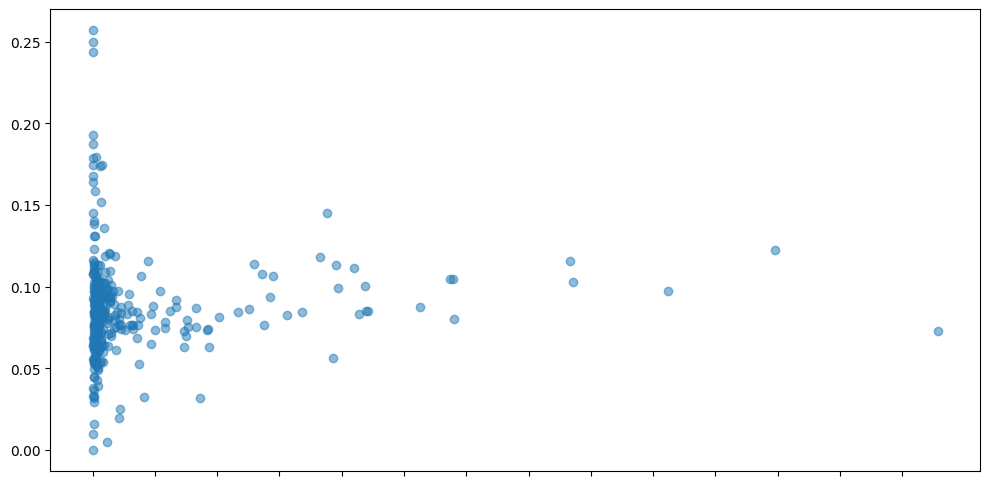

In [62]:
import matplotlib.pyplot as plt

# Crear el gráfico
plt.figure(figsize=(12, 6))
plt.scatter(airports['TOTAL_FLIGHTS'], airports['AIRPORT_DELAYS_PROPORTION'], alpha=0.5)
#new_ticks = np.arange(0, airports['TOTAL_FLIGHTS'].max(), 10000)  # Ajusta el 10000 según necesites
#plt.xticks(new_ticks)
plt.xticks(range(0, int(airports['TOTAL_FLIGHTS'].max()) + 1, 25000), [])
plt.show()

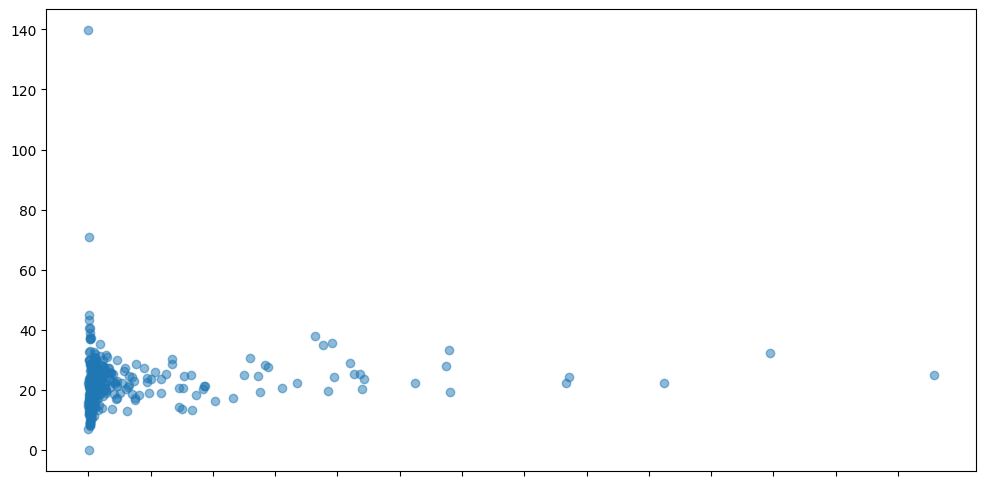

In [63]:
plt.figure(figsize=(12, 6))
plt.scatter(airports['TOTAL_FLIGHTS'], airports['AVG_AIRPORT_DELAY'], alpha=0.5)
#new_ticks = np.arange(0, airports['TOTAL_FLIGHTS'].max(), 10000)  # Ajusta el 10000 según necesites
#plt.xticks(new_ticks)
plt.xticks(range(0, int(airports['TOTAL_FLIGHTS'].max()) + 1, 25000), [])
plt.show()

In [64]:
small_airports = airports[airports['TOTAL_FLIGHTS'] < 25000]
joint_N_Flights = small_airports['TOTAL_FLIGHTS'].sum()
joint_N_AIRPORT_DELAYS = small_airports['N_AIRPORT_DELAYS'].sum()
joint_PROPORTION = joint_N_AIRPORT_DELAYS/joint_N_Flights
print(joint_PROPORTION)
joint_AVG = (small_airports['AVG_AIRPORT_DELAY']*small_airports['N_AIRPORT_DELAYS']).sum()/joint_N_AIRPORT_DELAYS
print(joint_AVG)
small_airports['AIRPORT_DELAYS_PROPORTION'] = joint_PROPORTION
small_airports['AVG_AIRPORT_DELAY'] = joint_AVG
airports.update(small_airports)
airports[['AIRPORT', 'AIRPORT_DELAYS_PROPORTION', 'AVG_AIRPORT_DELAY']]

0.08241654904091476
22.812207546734896


<ipython-input-64-bdb8bd51cf60>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_airports['AIRPORT_DELAYS_PROPORTION'] = joint_PROPORTION
<ipython-input-64-bdb8bd51cf60>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_airports['AVG_AIRPORT_DELAY'] = joint_AVG


,AIRPORT,AIRPORT_DELAYS_PROPORTION,AVG_AIRPORT_DELAY
0,CAK,0.082417,22.812208
1,RKS,0.082417,22.812208
2,IND,0.073781,23.798705
3,COU,0.082417,22.812208
4,OGG,0.082417,22.812208
...,...,...,...
317,ACV,0.082417,22.812208
318,CHO,0.082417,22.812208
319,FWA,0.082417,22.812208
320,LWS,0.082417,22.812208


In [65]:
airports.fillna(0)

,AIRPORT,TOTAL_FLIGHTS,FLIGHTS_M1,FLIGHTS_M2,FLIGHTS_M3,FLIGHTS_M4,FLIGHTS_M5,FLIGHTS_M6,FLIGHTS_M7,FLIGHTS_M8,...,PROPORTION_WEATHER_DELAY_M9,N_WEATHER_DELAYS_M10,AVG_WEATHER_DELAY_M10,PROPORTION_WEATHER_DELAY_M10,N_WEATHER_DELAYS_M11,AVG_WEATHER_DELAY_M11,PROPORTION_WEATHER_DELAY_M11,N_WEATHER_DELAYS_M12,AVG_WEATHER_DELAY_M12,PROPORTION_WEATHER_DELAY_M12
0,CAK,5955,572,480,678,561,611,555,561,496,...,0.004556,0,0.0,0.0,2,141.500000,0.003810,3,23.333333,0.006289
1,RKS,632,110,56,61,51,48,55,54,48,...,0.000000,0,0.0,0.0,1,45.000000,0.019608,1,73.000000,0.021277
2,IND,25115,2047,1778,2350,2312,2339,2367,2529,2321,...,0.005941,0,0.0,0.0,12,31.333333,0.004870,30,52.766667,0.012397
3,COU,1260,125,96,105,121,113,106,129,114,...,0.000000,0,0.0,0.0,5,77.800000,0.042017,3,35.666667,0.024793
4,OGG,20469,1872,1734,1939,1822,1796,1967,1936,1925,...,0.015508,0,0.0,0.0,3,24.666667,0.001707,6,28.000000,0.003030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,ACV,1269,138,126,97,109,110,107,123,111,...,0.026786,0,0.0,0.0,2,40.000000,0.015504,2,70.500000,0.018692
318,CHO,2142,197,161,200,177,212,174,191,212,...,0.000000,0,0.0,0.0,1,141.000000,0.004673,2,3.500000,0.010929
319,FWA,5074,308,340,467,495,533,475,528,495,...,0.003953,0,0.0,0.0,8,118.375000,0.016227,8,37.625000,0.018433
320,LWS,626,60,47,54,51,54,62,64,62,...,0.000000,0,0.0,0.0,0,0.000000,0.000000,1,581.000000,0.016129


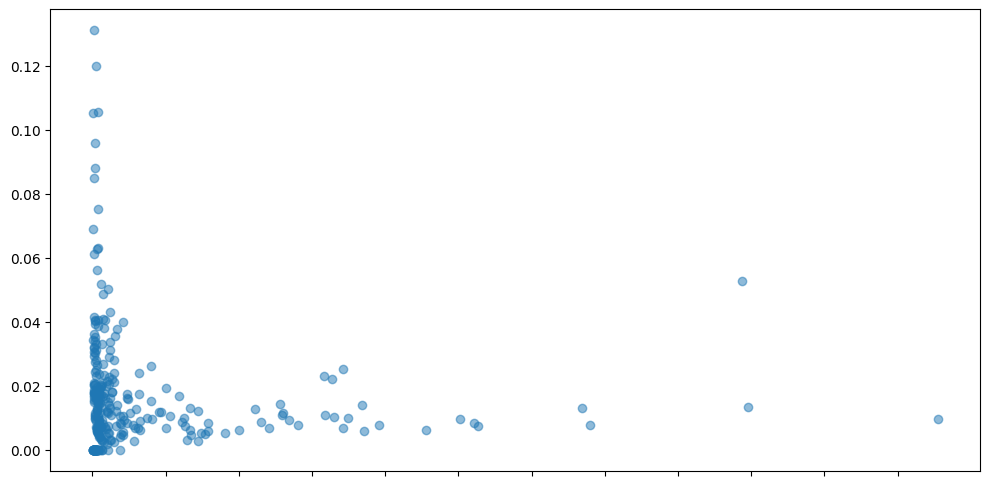

In [66]:
# Para Enero por ejemplo
plt.figure(figsize=(12, 6))
plt.scatter(airports['FLIGHTS_M1'], airports['PROPORTION_WEATHER_DELAY_M1'], alpha=0.5)
#new_ticks = np.arange(0, airports['TOTAL_FLIGHTS'].max(), 10000)  # Ajusta el 10000 según necesites
#plt.xticks(new_ticks)
plt.xticks(range(0, int(airports['FLIGHTS_M1'].max()) + 1, 2500), [])
plt.show()

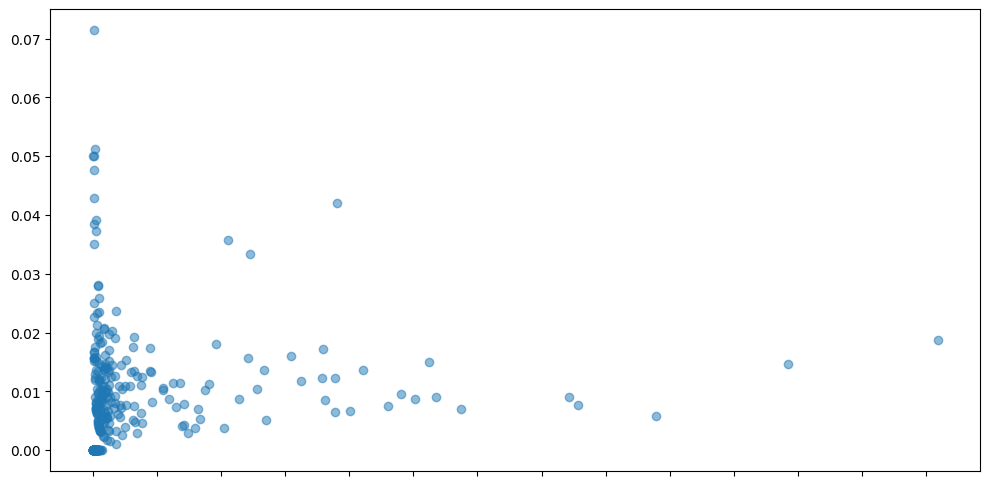

In [67]:
#Agosto
plt.figure(figsize=(12, 6))
plt.scatter(airports['FLIGHTS_M8'], airports['PROPORTION_WEATHER_DELAY_M8'], alpha=0.5)
#new_ticks = np.arange(0, airports['TOTAL_FLIGHTS'].max(), 10000)  # Ajusta el 10000 según necesites
#plt.xticks(new_ticks)
plt.xticks(range(0, int(airports['FLIGHTS_M8'].max()) + 1, 2500), [])
plt.show()

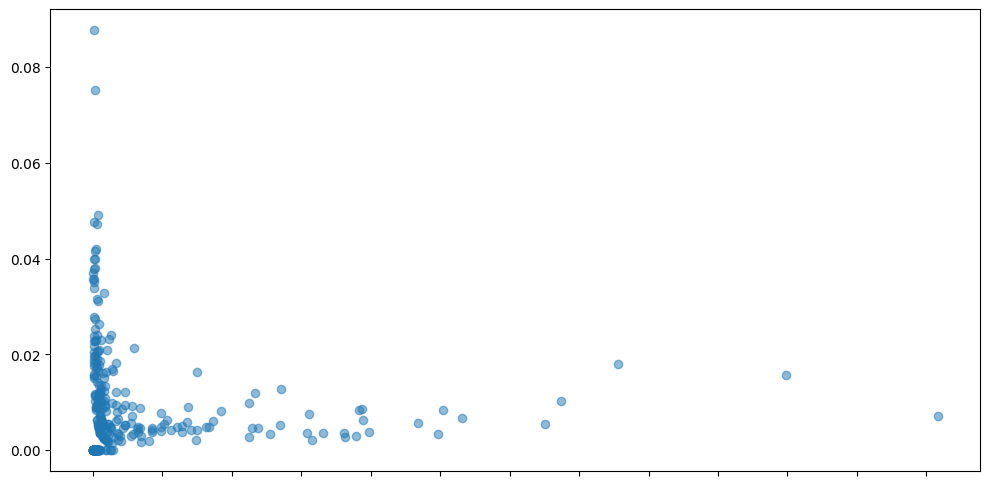

In [68]:
#Noviembre
plt.figure(figsize=(12, 6))
plt.scatter(airports['FLIGHTS_M11'], airports['PROPORTION_WEATHER_DELAY_M11'], alpha=0.5)
#new_ticks = np.arange(0, airports['TOTAL_FLIGHTS'].max(), 10000)  # Ajusta el 10000 según necesites
#plt.xticks(new_ticks)
plt.xticks(range(0, int(airports['FLIGHTS_M11'].max()) + 1, 2500), [])
plt.show()

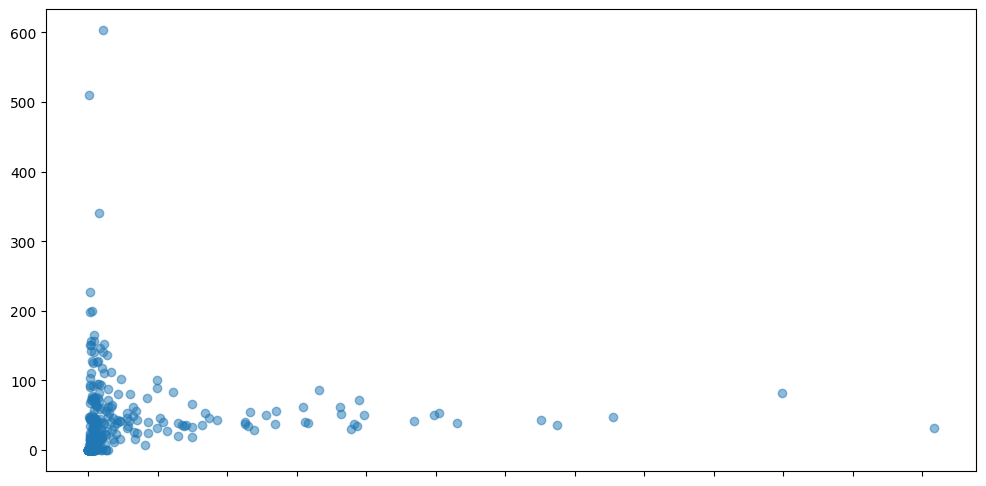

In [69]:
#Noviembre
plt.figure(figsize=(12, 6))
plt.scatter(airports['FLIGHTS_M11'], airports['AVG_WEATHER_DELAY_M11'], alpha=0.5)
#new_ticks = np.arange(0, airports['TOTAL_FLIGHTS'].max(), 10000)  # Ajusta el 10000 según necesites
#plt.xticks(new_ticks)
plt.xticks(range(0, int(airports['FLIGHTS_M11'].max()) + 1, 2500), [])
plt.show()

In [70]:
for month in range(1, 13):
    n_flights_label = 'FLIGHTS_M' + str(month)
    proportion_label = 'PROPORTION_WEATHER_DELAY_M' + str(month)
    avg_label = 'AVG_WEATHER_DELAY_M' + str(month)
    n_delays_label = 'N_WEATHER_DELAYS_M' + str(month)

    small_airports = airports[airports[n_flights_label] < 2500]
    small_airports['PROPORTION_WEATHER_DELAY_M' + str(month)] = (
        month_weather_delays[month][0]/max(month_flights[month], 1)
    )
    small_airports['AVG_WEATHER_DELAY_M' + str(month)] = (
        month_weather_delays[month][1]/max(month_weather_delays[month][0], 1)
    )
    airports.update(small_airports)

airports[['AIRPORT', 'FLIGHTS_M1','PROPORTION_WEATHER_DELAY_M1', 'AVG_WEATHER_DELAY_M1']]

<ipython-input-70-3fdca54d7b2a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_airports['PROPORTION_WEATHER_DELAY_M' + str(month)] = (
<ipython-input-70-3fdca54d7b2a>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_airports['AVG_WEATHER_DELAY_M' + str(month)] = (
<ipython-input-70-3fdca54d7b2a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

,AIRPORT,FLIGHTS_M1,PROPORTION_WEATHER_DELAY_M1,AVG_WEATHER_DELAY_M1
0,CAK,572,0.013530,42.248701
1,RKS,110,0.013530,42.248701
2,IND,2047,0.013530,42.248701
3,COU,125,0.013530,42.248701
4,OGG,1872,0.013530,42.248701
...,...,...,...,...
317,ACV,138,0.013530,42.248701
318,CHO,197,0.013530,42.248701
319,FWA,308,0.013530,42.248701
320,LWS,60,0.013530,42.248701


In [71]:
airports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 53 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   AIRPORT                       322 non-null    object 
 1   TOTAL_FLIGHTS                 322 non-null    int64  
 2   FLIGHTS_M1                    322 non-null    int64  
 3   FLIGHTS_M2                    322 non-null    int64  
 4   FLIGHTS_M3                    322 non-null    int64  
 5   FLIGHTS_M4                    322 non-null    int64  
 6   FLIGHTS_M5                    322 non-null    int64  
 7   FLIGHTS_M6                    322 non-null    int64  
 8   FLIGHTS_M7                    322 non-null    int64  
 9   FLIGHTS_M8                    322 non-null    int64  
 10  FLIGHTS_M9                    322 non-null    int64  
 11  FLIGHTS_M10                   322 non-null    int64  
 12  FLIGHTS_M11                   322 non-null    int64  
 13  FLIGH

In [72]:
columns_to_use = (
    ['AIRPORT', 'AIRPORT_DELAYS_PROPORTION', 'AVG_AIRPORT_DELAY'] +
    [('PROPORTION_WEATHER_DELAY_M' + str(month)) for month in range(1, 13)] +
    [('AVG_WEATHER_DELAY_M' + str(month)) for month in range(1, 13)]
)
airports = airports[columns_to_use]
airports

,AIRPORT,AIRPORT_DELAYS_PROPORTION,AVG_AIRPORT_DELAY,PROPORTION_WEATHER_DELAY_M1,PROPORTION_WEATHER_DELAY_M2,PROPORTION_WEATHER_DELAY_M3,PROPORTION_WEATHER_DELAY_M4,PROPORTION_WEATHER_DELAY_M5,PROPORTION_WEATHER_DELAY_M6,PROPORTION_WEATHER_DELAY_M7,...,AVG_WEATHER_DELAY_M3,AVG_WEATHER_DELAY_M4,AVG_WEATHER_DELAY_M5,AVG_WEATHER_DELAY_M6,AVG_WEATHER_DELAY_M7,AVG_WEATHER_DELAY_M8,AVG_WEATHER_DELAY_M9,AVG_WEATHER_DELAY_M10,AVG_WEATHER_DELAY_M11,AVG_WEATHER_DELAY_M12
0,CAK,0.082417,22.812208,0.013530,0.022058,0.009086,0.010171,0.012790,0.015490,0.010965,...,50.792716,43.325917,54.264121,50.631357,40.759444,46.308117,42.508105,0.0,51.905627,52.628621
1,RKS,0.082417,22.812208,0.013530,0.022058,0.009086,0.010171,0.012790,0.015490,0.010965,...,50.792716,43.325917,54.264121,50.631357,40.759444,46.308117,42.508105,0.0,51.905627,52.628621
2,IND,0.073781,23.798705,0.013530,0.022058,0.009086,0.010171,0.012790,0.015490,0.008304,...,50.792716,43.325917,54.264121,50.631357,57.809524,46.308117,42.508105,0.0,51.905627,52.628621
3,COU,0.082417,22.812208,0.013530,0.022058,0.009086,0.010171,0.012790,0.015490,0.010965,...,50.792716,43.325917,54.264121,50.631357,40.759444,46.308117,42.508105,0.0,51.905627,52.628621
4,OGG,0.082417,22.812208,0.013530,0.022058,0.009086,0.010171,0.012790,0.015490,0.010965,...,50.792716,43.325917,54.264121,50.631357,40.759444,46.308117,42.508105,0.0,51.905627,52.628621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,ACV,0.082417,22.812208,0.013530,0.022058,0.009086,0.010171,0.012790,0.015490,0.010965,...,50.792716,43.325917,54.264121,50.631357,40.759444,46.308117,42.508105,0.0,51.905627,52.628621
318,CHO,0.082417,22.812208,0.013530,0.022058,0.009086,0.010171,0.012790,0.015490,0.010965,...,50.792716,43.325917,54.264121,50.631357,40.759444,46.308117,42.508105,0.0,51.905627,52.628621
319,FWA,0.082417,22.812208,0.013530,0.022058,0.009086,0.010171,0.012790,0.015490,0.010965,...,50.792716,43.325917,54.264121,50.631357,40.759444,46.308117,42.508105,0.0,51.905627,52.628621
320,LWS,0.082417,22.812208,0.013530,0.022058,0.009086,0.010171,0.012790,0.015490,0.010965,...,50.792716,43.325917,54.264121,50.631357,40.759444,46.308117,42.508105,0.0,51.905627,52.628621


In [73]:
airports.describe().T

,count,mean,std,min,25%,50%,75%,max
AIRPORT_DELAYS_PROPORTION,322.0,0.083310,0.007754,0.032058,0.082417,0.082417,0.082417,0.145091
AVG_AIRPORT_DELAY,322.0,22.985899,2.149944,13.193816,22.812208,22.812208,22.812208,37.994444
PROPORTION_WEATHER_DELAY_M1,322.0,0.013174,0.003130,0.002765,0.013530,0.013530,0.013530,0.052845
PROPORTION_WEATHER_DELAY_M2,322.0,0.021568,0.004862,0.003436,0.022058,0.022058,0.022058,0.068917
PROPORTION_WEATHER_DELAY_M3,322.0,0.008980,0.002090,0.001695,0.009086,0.009086,0.009086,0.026853
PROPORTION_WEATHER_DELAY_M4,322.0,0.009981,0.002303,0.002129,0.010171,0.010171,0.010171,0.038288
PROPORTION_WEATHER_DELAY_M5,322.0,0.012720,0.003273,0.003258,0.012790,0.012790,0.012790,0.043740
PROPORTION_WEATHER_DELAY_M6,322.0,0.015390,0.002690,0.000967,0.015490,0.015490,0.015490,0.029435
PROPORTION_WEATHER_DELAY_M7,322.0,0.010893,0.002134,0.003012,0.010965,0.010965,0.010965,0.027812
PROPORTION_WEATHER_DELAY_M8,322.0,0.011580,0.002958,0.002945,0.011582,0.011582,0.011582,0.041956


In [74]:
airports.to_csv('airports_fixed_encoding.csv', index= False)

In [75]:
import pickle
with open('airport_saturation.pkl', 'wb') as f:
    pickle.dump(airport_saturation, f)

**Feature Engineering**

In [76]:
df = pd.read_csv('/content/clean_flights_data.csv')

In [77]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MONTH,2602619.0,6.228491,3.378206,1.0,3.0,6.0,9.0,12.0
SCHEDULED_STATIONED_TIME,2602619.0,196.923980,1572.410913,0.0,0.0,30.0,64.0,476068.0
SCHEDULED_DEPARTURE,2602619.0,249785.668547,148589.843852,5.0,125225.0,242830.0,358196.0,525599.0
DEPARTURE_DELAY,2602619.0,9.366669,36.768317,-61.0,-5.0,-2.0,8.0,1670.0
SCHEDULED_ARRIVAL,2602619.0,249930.764028,148591.028517,270.0,125654.0,242975.0,358337.0,526926.0
ARRIVAL_DELAY,2602619.0,4.560171,39.222339,-87.0,-13.0,-5.0,8.0,1665.0
MATCH,2602619.0,0.542877,0.498158,0.0,0.0,1.0,1.0,1.0
TEST,2602619.0,0.200000,0.400000,0.0,0.0,0.0,0.0,1.0


In [78]:
saturation = pd.read_csv('/content/flights_saturations')
df = pd.merge(df, saturation, on= ['TAIL_NUMBER', 'SCHEDULED_DEPARTURE'])

In [79]:
def split_flight(flight):
    """Splits a flight in the two operations that forms it (departure and arrival)"""

    common = [
        flight.AIRLINE,
        flight.ORIGIN_AIRPORT,
        flight.DESTINATION_AIRPORT,
        flight.TAIL_NUMBER,
        flight.MONTH,
        flight.TEST
    ]

    departure = common + [
        flight.MATCH,
        'DEPARTURE',
        flight.SCHEDULED_DEPARTURE,
        flight.ORIGIN_SATURATION,
        flight.SCHEDULED_STATIONED_TIME,
        flight.DEPARTURE_DELAY
    ]

    arrival = common + [
        1,
        'ARRIVAL',
        flight.SCHEDULED_ARRIVAL,
        flight.DESTINATION_SATURATION,
        flight.SCHEDULED_ARRIVAL - flight.SCHEDULED_DEPARTURE,
        flight.ARRIVAL_DELAY
    ]

    return [departure, arrival]

rows = []
columns = [
    'AIRLINE',
    'ORIGIN_AIRPORT',
    'DESTINATION_AIRPORT',
    'TAIL_NUMBER',
    'MONTH',
    'TEST',
    'MATCH',
    'ORIENTATION',
    'TIME',
    'SATURATION',
    'TFD',
    'DELAY',
    ]

for flight in df.itertuples(index= False):
    rows += split_flight(flight)
df = pd.DataFrame(rows, columns= columns)
df

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,TAIL_NUMBER,MONTH,TEST,MATCH,ORIENTATION,TIME,SATURATION,TFD,DELAY
0,WN,BNA,LGA,7819A,7,0,0,DEPARTURE,275400,0.312500,0,-4.0
1,WN,BNA,LGA,7819A,7,0,1,ARRIVAL,275590,0.137500,190,-7.0
2,WN,STL,ATL,7819A,7,0,0,DEPARTURE,275760,0.187500,0,-4.0
3,WN,STL,ATL,7819A,7,0,1,ARRIVAL,275915,0.190476,155,-15.0
4,WN,TPA,MSY,7819A,7,0,0,DEPARTURE,276080,0.267857,0,144.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5205549,MQ,ORD,ROC,N9EAMQ,12,1,1,ARRIVAL,524013,0.166667,158,1.0
5205550,MQ,ROC,ORD,N9EAMQ,12,0,1,DEPARTURE,524740,0.375000,727,0.0
5205551,MQ,ROC,ORD,N9EAMQ,12,0,1,ARRIVAL,524810,0.305556,70,-13.0
5205552,MQ,ORD,ASE,N9EAMQ,12,0,1,DEPARTURE,524875,0.250000,65,-2.0


In [80]:
df['PFD'] = df['DELAY'].shift(1, fill_value= 0)*df['MATCH']
df

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,TAIL_NUMBER,MONTH,TEST,MATCH,ORIENTATION,TIME,SATURATION,TFD,DELAY,PFD
0,WN,BNA,LGA,7819A,7,0,0,DEPARTURE,275400,0.312500,0,-4.0,0.0
1,WN,BNA,LGA,7819A,7,0,1,ARRIVAL,275590,0.137500,190,-7.0,-4.0
2,WN,STL,ATL,7819A,7,0,0,DEPARTURE,275760,0.187500,0,-4.0,-0.0
3,WN,STL,ATL,7819A,7,0,1,ARRIVAL,275915,0.190476,155,-15.0,-4.0
4,WN,TPA,MSY,7819A,7,0,0,DEPARTURE,276080,0.267857,0,144.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5205549,MQ,ORD,ROC,N9EAMQ,12,1,1,ARRIVAL,524013,0.166667,158,1.0,-2.0
5205550,MQ,ROC,ORD,N9EAMQ,12,0,1,DEPARTURE,524740,0.375000,727,0.0,1.0
5205551,MQ,ROC,ORD,N9EAMQ,12,0,1,ARRIVAL,524810,0.305556,70,-13.0,0.0
5205552,MQ,ORD,ASE,N9EAMQ,12,0,1,DEPARTURE,524875,0.250000,65,-2.0,-13.0


In [82]:
airlines_encoding = pd.read_csv('/content/airlines_encoding.csv')
airlines_encoding

,AIRLINE,GLOBAL_DELAYS_PROPORTION,GLOBAL_AVG_DELAY
0,WN,0.140,25.1
1,DL,0.088,41.2
2,AA,0.116,40.3
3,MQ,0.120,38.0
4,EV,0.116,43.0
5,US,0.120,31.8
6,OO,0.079,50.8
7,UA,0.158,33.6
8,B6,0.176,26.3
9,F9,0.160,30.1


In [83]:
df = pd.merge(df, airlines_encoding, on= 'AIRLINE').drop('AIRLINE', axis= 1)
df.rename(columns= {'GLOBAL_DELAYS_PROPORTION' : 'AIRLINE_DELAY_PROB',
                    'GLOBAL_AVG_DELAY' : 'AIRLINE_AVG_DELAY'}, inplace= True)
df

,ORIGIN_AIRPORT,DESTINATION_AIRPORT,TAIL_NUMBER,MONTH,TEST,MATCH,ORIENTATION,TIME,SATURATION,TFD,DELAY,PFD,AIRLINE_DELAY_PROB,AIRLINE_AVG_DELAY
0,BNA,LGA,7819A,7,0,0,DEPARTURE,275400,0.312500,0,-4.0,0.0,0.14,25.1
1,BNA,LGA,7819A,7,0,1,ARRIVAL,275590,0.137500,190,-7.0,-4.0,0.14,25.1
2,STL,ATL,7819A,7,0,0,DEPARTURE,275760,0.187500,0,-4.0,-0.0,0.14,25.1
3,STL,ATL,7819A,7,0,1,ARRIVAL,275915,0.190476,155,-15.0,-4.0,0.14,25.1
4,TPA,MSY,7819A,7,0,0,DEPARTURE,276080,0.267857,0,144.0,-0.0,0.14,25.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5205549,ORD,ROC,N9EAMQ,12,1,1,ARRIVAL,524013,0.166667,158,1.0,-2.0,0.12,38.0
5205550,ROC,ORD,N9EAMQ,12,0,1,DEPARTURE,524740,0.375000,727,0.0,1.0,0.12,38.0
5205551,ROC,ORD,N9EAMQ,12,0,1,ARRIVAL,524810,0.305556,70,-13.0,0.0,0.12,38.0
5205552,ORD,ASE,N9EAMQ,12,0,1,DEPARTURE,524875,0.250000,65,-2.0,-13.0,0.12,38.0


In [84]:
airports_encoding = pd.read_csv('/content/airports_fixed_encoding.csv')
airports_encoding.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   AIRPORT                       322 non-null    object 
 1   AIRPORT_DELAYS_PROPORTION     322 non-null    float64
 2   AVG_AIRPORT_DELAY             322 non-null    float64
 3   PROPORTION_WEATHER_DELAY_M1   322 non-null    float64
 4   PROPORTION_WEATHER_DELAY_M2   322 non-null    float64
 5   PROPORTION_WEATHER_DELAY_M3   322 non-null    float64
 6   PROPORTION_WEATHER_DELAY_M4   322 non-null    float64
 7   PROPORTION_WEATHER_DELAY_M5   322 non-null    float64
 8   PROPORTION_WEATHER_DELAY_M6   322 non-null    float64
 9   PROPORTION_WEATHER_DELAY_M7   322 non-null    float64
 10  PROPORTION_WEATHER_DELAY_M8   322 non-null    float64
 11  PROPORTION_WEATHER_DELAY_M9   322 non-null    float64
 12  PROPORTION_WEATHER_DELAY_M10  322 non-null    float64
 13  PROPO

In [85]:
df = pd.merge(df, airports_encoding,
              left_on= 'ORIGIN_AIRPORT',
              right_on= 'AIRPORT',
             )

In [86]:
origin_weather_delay_prob = []
origin_avg_weather_delay = []
for row in df.itertuples(index= False):
    month = row.MONTH
    column_name = 'PROPORTION_WEATHER_DELAY_M' + str(month)
    origin_weather_delay_prob.append(getattr(row, column_name))
    column_name = 'AVG_WEATHER_DELAY_M' + str(month)
    origin_avg_weather_delay.append(getattr(row, column_name))
df['ORIGIN_WEATHER_DELAY_PROB'] = pd.DataFrame(origin_weather_delay_prob, columns= ['ORIGIN_WEATHER_DELAY_PROB'])
df['ORIGIN_AVG_WEATHER_DELAY'] = pd.DataFrame(origin_avg_weather_delay, columns= ['ORIGIN_AVG_WEATHER_DELAY'])

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5205554 entries, 0 to 5205553
Data columns (total 43 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   ORIGIN_AIRPORT                object 
 1   DESTINATION_AIRPORT           object 
 2   TAIL_NUMBER                   object 
 3   MONTH                         int64  
 4   TEST                          int64  
 5   MATCH                         int64  
 6   ORIENTATION                   object 
 7   TIME                          int64  
 8   SATURATION                    float64
 9   TFD                           int64  
 10  DELAY                         float64
 11  PFD                           float64
 12  AIRLINE_DELAY_PROB            float64
 13  AIRLINE_AVG_DELAY             float64
 14  AIRPORT                       object 
 15  AIRPORT_DELAYS_PROPORTION     float64
 16  AVG_AIRPORT_DELAY             float64
 17  PROPORTION_WEATHER_DELAY_M1   float64
 18  PROPORTION_WEATHER_DEL

In [88]:
df.rename(columns= {'AIRPORT_DELAYS_PROPORTION' : 'ORIGIN_AIRPORT_DELAY_PROB',
                   'AVG_AIRPORT_DELAY' : 'ORIGIN_AIRPORT_AVG_DELAY'}, inplace= True)
columns_to_drop = (
    [('PROPORTION_WEATHER_DELAY_M' + str(month)) for month in range(1, 13)] +
    [('AVG_WEATHER_DELAY_M' + str(month)) for month in range(1, 13)] + ['AIRPORT']
)
df.drop(columns= columns_to_drop, inplace= True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5205554 entries, 0 to 5205553
Data columns (total 18 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   ORIGIN_AIRPORT             object 
 1   DESTINATION_AIRPORT        object 
 2   TAIL_NUMBER                object 
 3   MONTH                      int64  
 4   TEST                       int64  
 5   MATCH                      int64  
 6   ORIENTATION                object 
 7   TIME                       int64  
 8   SATURATION                 float64
 9   TFD                        int64  
 10  DELAY                      float64
 11  PFD                        float64
 12  AIRLINE_DELAY_PROB         float64
 13  AIRLINE_AVG_DELAY          float64
 14  ORIGIN_AIRPORT_DELAY_PROB  float64
 15  ORIGIN_AIRPORT_AVG_DELAY   float64
 16  ORIGIN_WEATHER_DELAY_PROB  float64
 17  ORIGIN_AVG_WEATHER_DELAY   float64
dtypes: float64(9), int64(5), object(4)
memory usage: 714.9+ MB


In [89]:
df = pd.merge(df, airports_encoding,
              left_on= 'DESTINATION_AIRPORT',
              right_on= 'AIRPORT',
             )
destination_weather_delay_prob = []
destination_avg_weather_delay = []
for row in df.itertuples(index= False):
    month = row.MONTH
    column_name = 'PROPORTION_WEATHER_DELAY_M' + str(month)
    destination_weather_delay_prob.append(getattr(row, column_name))
    column_name = 'AVG_WEATHER_DELAY_M' + str(month)
    destination_avg_weather_delay.append(getattr(row, column_name))
df['DESTINATION_WEATHER_DELAY_PROB'] = pd.DataFrame(destination_weather_delay_prob, columns= ['DESTINATION_WEATHER_DELAY_PROB'])
df['DESTINATION_AVG_WEATHER_DELAY'] = pd.DataFrame(destination_avg_weather_delay, columns= ['DESTINATION_AVG_WEATHER_DELAY'])
df.rename(columns= {'AIRPORT_DELAYS_PROPORTION' : 'DESTINATION_AIRPORT_DELAY_PROB',
                   'AVG_AIRPORT_DELAY' : 'DESTINATION_AIRPORT_AVG_DELAY'}, inplace= True)
columns_to_drop = (
    [('PROPORTION_WEATHER_DELAY_M' + str(month)) for month in range(1, 13)] +
    [('AVG_WEATHER_DELAY_M' + str(month)) for month in range(1, 13)] + ['AIRPORT']
)
df.drop(columns= columns_to_drop, inplace= True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5205554 entries, 0 to 5205553
Data columns (total 22 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   ORIGIN_AIRPORT                  object 
 1   DESTINATION_AIRPORT             object 
 2   TAIL_NUMBER                     object 
 3   MONTH                           int64  
 4   TEST                            int64  
 5   MATCH                           int64  
 6   ORIENTATION                     object 
 7   TIME                            int64  
 8   SATURATION                      float64
 9   TFD                             int64  
 10  DELAY                           float64
 11  PFD                             float64
 12  AIRLINE_DELAY_PROB              float64
 13  AIRLINE_AVG_DELAY               float64
 14  ORIGIN_AIRPORT_DELAY_PROB       float64
 15  ORIGIN_AIRPORT_AVG_DELAY        float64
 16  ORIGIN_WEATHER_DELAY_PROB       float64
 17  ORIGIN_AVG_WEATHER_DELAY   

In [90]:
columns_to_drop = ['TAIL_NUMBER', 'TIME', 'MONTH', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']
df = df.drop(columns= columns_to_drop, axis= 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5205554 entries, 0 to 5205553
Data columns (total 17 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   TEST                            int64  
 1   MATCH                           int64  
 2   ORIENTATION                     object 
 3   SATURATION                      float64
 4   TFD                             int64  
 5   DELAY                           float64
 6   PFD                             float64
 7   AIRLINE_DELAY_PROB              float64
 8   AIRLINE_AVG_DELAY               float64
 9   ORIGIN_AIRPORT_DELAY_PROB       float64
 10  ORIGIN_AIRPORT_AVG_DELAY        float64
 11  ORIGIN_WEATHER_DELAY_PROB       float64
 12  ORIGIN_AVG_WEATHER_DELAY        float64
 13  DESTINATION_AIRPORT_DELAY_PROB  float64
 14  DESTINATION_AIRPORT_AVG_DELAY   float64
 15  DESTINATION_WEATHER_DELAY_PROB  float64
 16  DESTINATION_AVG_WEATHER_DELAY   float64
dtypes: float64(13), int64(3), o

In [91]:
delay_column = df.pop('DELAY')
df = pd.concat([df, delay_column], axis= 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5205554 entries, 0 to 5205553
Data columns (total 17 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   TEST                            int64  
 1   MATCH                           int64  
 2   ORIENTATION                     object 
 3   SATURATION                      float64
 4   TFD                             int64  
 5   PFD                             float64
 6   AIRLINE_DELAY_PROB              float64
 7   AIRLINE_AVG_DELAY               float64
 8   ORIGIN_AIRPORT_DELAY_PROB       float64
 9   ORIGIN_AIRPORT_AVG_DELAY        float64
 10  ORIGIN_WEATHER_DELAY_PROB       float64
 11  ORIGIN_AVG_WEATHER_DELAY        float64
 12  DESTINATION_AIRPORT_DELAY_PROB  float64
 13  DESTINATION_AIRPORT_AVG_DELAY   float64
 14  DESTINATION_WEATHER_DELAY_PROB  float64
 15  DESTINATION_AVG_WEATHER_DELAY   float64
 16  DELAY                           float64
dtypes: float64(13), int64(3), o

In [92]:
df.to_csv('data_is_ready.csv', index= False)